In [1]:
import sys
import os
import json

import numpy as np

sys.path.insert(0, os.path.abspath(".."))

import AetheriaPackage.ISA_tool as ISA
import AetheriaPackage.GeneralConstants as const
from AetheriaPackage.structures import calc_fuselage_weight as old_calc_fuselage_weight

d:\OneDrive - Delft University of Technology\Honours\02 Python\Honours Project\AetheriaPackage\AetheriaPackage\GeneralConstants.py:83: UserWarning: Missing nacelles data/counteracting effect for our design
  warn("Missing nacelles data/counteracting effect for our design")


In [ ]:
file_path = r'C:\Users\Alfon\OneDrive - Delft University of Technology\Honours\02 Python\Honours Project\AetheriaPackage\output\_beta_sensitivity_3\run_optimizaton_b=0.510_Jun-01_22.03\design_state_b=0.510_Jun-01_22.03.json'

with open(file_path, 'r') as f:
    d = json.load(f)

### Testing Fix of TAS -> EAS in Fuselage C2WE

In [ ]:
cruise = ISA.ISA(const.h_cruise)
sea_level = ISA.ISA(0)

V_EAS = const.v_cr*np.sqrt(cruise.density()/sea_level.density())
V_EAS, const.v_cr

In [ ]:
d['Fuselage']['fuselage_weight']

In [ ]:
old_calc_fuselage_weight(mtom=d['AircraftParameters']['MTOM'],
                     lf=d['Fuselage']['length_fuselage'],
                     nult=d['AircraftParameters']['n_ult'],
                     wf=d['Fuselage']['width_fuselage_outer'],
                     hf=d['Fuselage']['height_fuselage_outer'],
                     v_cr=const.v_cr,
                     rho_cr=const.rho_cr,
                     rho_sl=const.rho_sl
                     )

### Updating C2WE with Separate Tail Contribution

In [ ]:
def calc_fuselage_weight(mtom:float, nult:float, v_cr:float, rho_cr:float, rho_sl:float, 
                         lf:float,  wf:float, hf:float, separate_tail=False,
                         lt:float=None, wt:float=None, ht:float=None) -> float:
    """ Returns mass of fuselage subsystem, using USAF method. 
    See Eq 5.25 (pg 76) Pt 5. Component Weight Estimation (Roskam).

    :param mtom: Maximum take off mass (Kg)
    :type mtom: float
    :param nult: Ultimate load factor (-)
    :type nult: float
    :param v_cr: design cruise speed  (m/s)
    :type v_cr: float
    :param rho_cr: Density at cruise altitude (Kg/m3)
    :type rho_cr: float
    :param rho_sl: Density at sea-level altitude (Kg/m3)
    :type rho_sl: float
    :param lf: Fuselage length (m)
    :type lf: float
    :param wf: Maximum fuselage width (m)
    :type wf: float
    :param hf: Maximum fuselage height (m)
    :type hf: float
    :param separate_tail: Specify if the tail is to be considered 
        separately, as an add-on fuselage. By default False
    :type separate_tail: bool
    :param lt: Tail length (m). Only required if separate_tail=True.
    :type lt: float
    :param wt: End-of-tail width (m) Only required if separate_tail=True.
    :type wt: float
    :param ht: End-of-tail height (m) Only required if separate_tail=True.
    :type ht: float

    # THE FOLLOWING IS FOR CESSNA METHOD, WHICH IS NOT USED
    # :param max_per:  Maximium perimeter of the fuselage
    # :type max_per: float
    # :param npax: Amount of passengers including pilot
    # :type npax: int
    """

    # Convert to Imperial Units
    mtow_lbs = 2.20462 * mtom
    lf_ft = lf*3.28084
    nult = nult # ultimate load factor
    wf_ft = wf*3.28084 # width fuselage [ft]
    hf_ft = hf*3.28084 # height fuselage [ft]
    Vc_kts = v_cr*(rho_cr/rho_sl)**0.5*1.94384449 # design cruise speed [kts] (convert TAS -> EAS)

    
    fweigh_USAF = 200*((mtow_lbs*nult/10**5)**0.286*(lf_ft/10)**0.857*((wf_ft+hf_ft)/10)*(Vc_kts/100)**0.338)**1.1
    return fweigh_USAF*0.453592  

    #if identifier == "J1":
    #    # THIS IS CESSNA METHOD
    #    fweight_high = 14.86*(mtow_lbs**0.144)*((lf_ft/max_per_ft)**0.778)*(lf_ft**0.383)*(npax**0.455)
    #    mass = fweight_high*0.453592
    #else:
    #    fweight_high = 14.86*(mtow_lbs**0.144)*((lf_ft/max_per_ft)**0.778)*(lf_ft**0.383)*(npax**0.455)
    #    fweight_low = 0.04682*(mtow_lbs**0.692)*(max_per_ft**0.374)*(lf_ft**0.590)
    #    fweight = (fweight_high + fweight_low)/2
    #    mass = fweight*0.453592

In [ ]:
2.3*None

### Testing Roskam C2WE for a Propeller

In [ ]:
n_blades = 6
n_engines = 6
D = 2*d['Engine']['prop_radius']*3.28084
Pto = d['AircraftParameters']['hoverPower']/n_engines*0.00134102
Kprop = 31.92

Kprop*n_blades**0.391*(D*Pto/1000)**0.782

## Modeling Surface Area of Aetheria

### Tailcone Modelling
Skewed frustum

In [1]:
import sys
import os

import numpy as np
import scipy as sp
import scipy.integrate
import matplotlib.pyplot as plt
%matplotlib widget

sys.path.insert(0, os.path.abspath(".."))

from AetheriaPackage.basic_functions import Linear
import AetheriaPackage.tail_plotter_tools as tpt

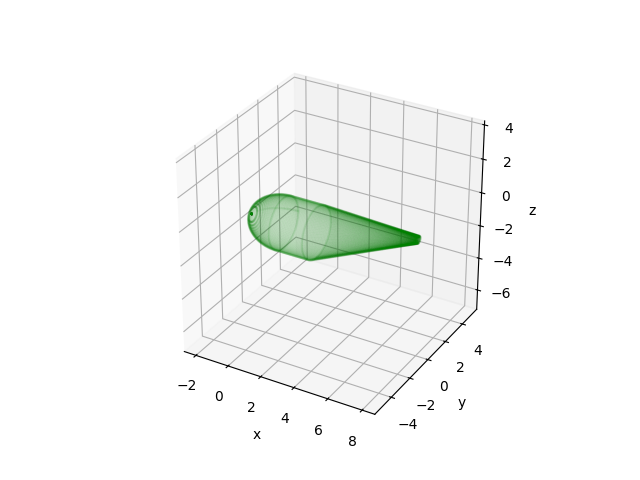

69.4785569216035

In [3]:
def calc_fus_surface(D_fus:float, l_fuse:float, l_nose:float, 
                     l_tail:float, D_end:float, plot:bool=False,
                     **style):
    '''Function to calculate the surface area of the fuselage.
    
    The implemented models breaks the fuselage into the following three components:
    1. Nosecone, as half of a 3D ellipsoid
    2. Tailcone, as a sheared/skewed frustrum
    3. Cylindrical part of fuselage.
    
    Throughout the function, the following abbreviations are used:
    nc       : nosecone
    tc       : tailcone
    fuse     : fuselage
    fun      : function
    fun_diff : derivative function

    The coordinate system is changed for the integration of each component, this makes
    reference to x, y, z different between components.

    Parameters
    ----------
    D_fus: FLOAT [m]
        Maximum diameter of fuselage.
    l_fuse: FLOAT [m]
        Length of fuselage
    l_nose: FLOAT [m]
        Length of nosecone. 
    l_tail: FLOAT [m]
        Length of tailcone.
    D_end: FLOAT [m]
        Maximum cross-section length at the end of the tail.
    plot: BOOL (default: FALSE)
        Specify whether to plot the fuselage in 3D.
    
    Returns
    -------
    S : FLOAT [m2]
        Surface area of the fusealge.
    '''
    # Define constants for the rest of the module.
    R0 = D_fus/2
    Rf = D_end/2
    l_cyl = l_fuse-l_tail-l_nose

    # Initialise plotting, if needed.
    if plot:
        ax = plt.figure().add_subplot(projection='3d')
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('z')
    
    # 1. NOSECONE
    ### ------------------------------------------------------------
    # Define the radius function (ellipse)
    rho_fun      = lambda z: R0*np.sqrt(1-z**2/l_nose**2)
    rho_fun_diff = lambda z: R0*(1/2)*(1-z**2/l_nose**2)**(-1/2)*(-2*z/l_nose**2)

    # Defining the surface, as a parametrization of theta, z
    r_nc    = lambda theta, z : np.array([rho_fun(z)*np.cos(theta),
                                        rho_fun(z)*np.sin(theta), 
                                        z                        ]) 

    # Derivative of r_nc w.r.t. theta
    r_nc_theta = lambda theta, z : np.array([-rho_fun(z)*np.sin(theta), 
                                            rho_fun(z)*np.cos(theta) , 
                                            np.zeros(np.shape(z))     ])

    # Derivative of r_nc w.r.t. z
    r_nc_z     = lambda theta, z : np.array([rho_fun_diff(z)*np.cos(theta), 
                                            rho_fun_diff(z)*np.sin(theta), 
                                            np.ones(np.shape(z))])

    # Defining the integrand
    nosecone_surface_integrand = lambda theta, z: np.linalg.norm(np.cross(r_nc_theta(theta, z), r_nc_z(theta, z)))

    # integrate
    S_nc = sp.integrate.dblquad(nosecone_surface_integrand, 0, l_nose, 0, 2*np.pi)[0]

    if plot:
        # plot the surface
        z_lst = np.linspace(0, l_nose, 25)
        t_lst = np.linspace(0, 2*np.pi, 100)

        zz, tt = np.meshgrid(z_lst, t_lst)

        xx, yy, zz = r_nc(tt, zz)

        ax.scatter(-zz, xx, -yy-R0, s=1,**style)

    # 2. TAILCONE
    ### ------------------------------------------------------------

    # Define radius of the cone as function of the length along the tail.
    rho_fun = Linear(0, l_tail, R0, Rf)
    # Define deviation of the centre of the circle as function of length
    # along the tail
    eps_fun = Linear(0, l_tail, 0, (R0-Rf))

    # Defining the surface as a parametrization of theta, z
    r_tc    = lambda theta, z : np.array([rho_fun(z)*np.sin(theta)                , 
                                        R0 - eps_fun(z) + rho_fun(z)*np.cos(theta), 
                                        z                                          ]) 

    # Derivative of r_tc w.r.t. theta
    r_tc_theta = lambda theta, z : np.array([rho_fun(z)*np.cos(theta) , 
                                            -rho_fun(z)*np.sin(theta), 
                                            np.zeros(np.shape(z))     ])

    # Derivative of r_tc w.r.t. z
    r_tc_z     = lambda theta, z : np.array([rho_fun.diff(z)*np.sin(theta), 
                                             -eps_fun.diff(z)+rho_fun.diff(z)*np.cos(theta), 
                                             np.ones(np.shape(z))])

    # Defining the integrand
    tailcone_surface_integrand = lambda theta, z: np.linalg.norm(np.cross(r_tc_theta(theta, z), r_tc_z(theta, z)))

    # integrate
    S_tl = sp.integrate.dblquad(tailcone_surface_integrand, 0, l_tail, 0, 2*np.pi)[0]

    # account for cap a the end of the tail
    S_tl += np.pi*Rf**2

    if plot:
        # plot the surface
        z_lst = np.linspace(0, l_tail, 80)
        t_lst = np.linspace(0, 2*np.pi, 100)

        zz, tt = np.meshgrid(z_lst, t_lst)

        xx, yy, zz = r_tc(tt, zz)

        ax.scatter(zz+l_cyl, xx, -yy, s=1, **style)

    # 3. Cylindrical part of Fuselage
    ### ------------------------------------------------------------
    S_cyl = 2*np.pi*R0*l_cyl

    if plot:
        tpt.plot_cylinder(ax, R0, l_cyl, 0, 0, -R0, caps=False, n=100, **style)

        tpt.set_axes_equal(ax)
        plt.show()

    # ALL. Putting Everything Together
    ### ------------------------------------------------------------

    # Calculate total surface
    S = S_nc + S_tl + S_cyl

    return S

calc_fus_surface(3, 10, 2, 6, 0.4, plot=True, alpha=0.05, color='green')

In [7]:
R0 = 3 #m (outer radius of fuselage)
Rf = 3/4 #m (radius at the end of the tail)
l_tail = 10 #m (length of tail)

rho_fun = Linear(0, l_tail, R0, Rf)
eps_fun = Linear(0, l_tail, 0, (R0-Rf))

# Defining the surface (tc stands for tail cone)
r_tc    = lambda theta, z : np.array([rho_fun(z)*np.sin(theta)                  , 
                                      R0 - eps_fun(z) + rho_fun(z)*np.cos(theta), 
                                      z                                          ]) 

# derivative w.r.t. theta
r_tc_theta = lambda theta, z : np.array([rho_fun(z)*np.cos(theta) , 
                                         -rho_fun(z)*np.sin(theta), 
                                         np.zeros(np.shape(z))     ])

# derivative w.r.t. z
r_tc_z     = lambda theta, z : np.array([rho_fun.diff(z)*np.sin(theta), 
                                      -eps_fun.diff(z)+rho_fun.diff(z)*np.cos(theta), 
                                      np.ones(np.shape(z))])

# defining the integrand
tailcone_surface_integrand = lambda theta, z: np.linalg.norm(np.cross(r_theta(theta, z), r_z(theta, z)))

# integrate
tailcone_surface = sp.integrate.dblquad(tailcone_surface_integrand, 0, l_tail, 0, 2*np.pi)

tailcone_surface

(122.13013552082856, 1.3559168845581454e-12)

56.548667764616276

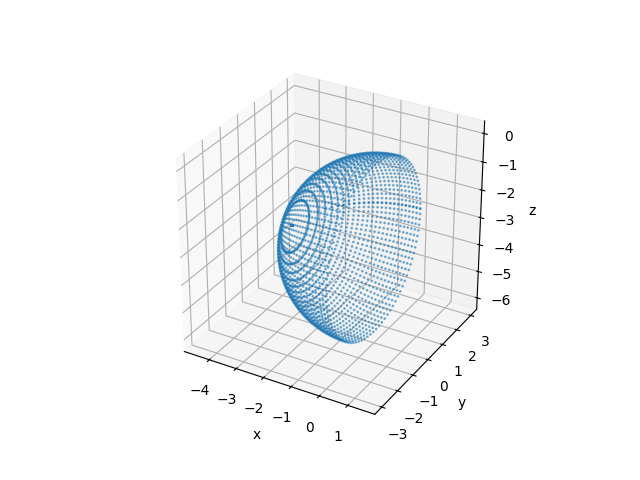

In [13]:
plot = True
l_nose = 3 #m
R0 = 3 #m
# -------------------------
# Initialise plotting, if needed.
if plot:
    ax = plt.figure().add_subplot(projection='3d')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')

# 1. NOSECONE
### ------------------------------------------------------------
# (nc stands for nose cone)
# Define the radius function (ellipse)
rho_fun      = lambda z: R0*np.sqrt(1-z**2/l_nose**2)
rho_fun_diff = lambda z: R0*(1/2)*(1-z**2/l_nose**2)**(-1/2)*(-2*z/l_nose**2)

# Defining the surface, as a parametrization of theta and z. 
r_nc    = lambda theta, z : np.array([rho_fun(z)*np.cos(theta),
                                    rho_fun(z)*np.sin(theta), 
                                    z                        ]) 

# Derivative of r_nc w.r.t. theta
r_nc_theta = lambda theta, z : np.array([-rho_fun(z)*np.sin(theta), 
                                        rho_fun(z)*np.cos(theta) , 
                                        np.zeros(np.shape(z))     ])

# Derivative of r_nc w.r.t. z
r_nc_z     = lambda theta, z : np.array([rho_fun_diff(z)*np.cos(theta), 
                                        rho_fun_diff(z)*np.sin(theta), 
                                        np.ones(np.shape(z))])

# Defining the integrand
nosecone_surface_integrand = lambda theta, z: np.linalg.norm(np.cross(r_nc_theta(theta, z), r_nc_z(theta, z)))

# integrate
S_nc = sp.integrate.dblquad(nosecone_surface_integrand, 0, l_nose, 0, 2*np.pi)[0]

if plot:
    # plot the surface
    z_lst = np.linspace(0, l_nose, 25)
    t_lst = np.linspace(0, 2*np.pi, 100)

    zz, tt = np.meshgrid(z_lst, t_lst)

    xx, yy, zz = r_nc(tt, zz)

    ax.scatter(-zz, xx, -yy-R0, s=1, alpha=0.5)
    tpt.set_axes_equal(ax)


S_nc

In [12]:
4*np.pi*R0**2/2

56.548667764616276